In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split

In [2]:
images_csv = pd.read_csv('data.csv')

In [3]:
images_csv = images_csv[['path', 'label']]
images_csv.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [4]:
emotions = images_csv['label'].unique()
emotions_dic = {}
for index, emotion in enumerate(emotions):
    emotions_dic[emotion] = index

print(emotions_dic)

{'Surprise': 0, 'Sad': 1, 'Ahegao': 2, 'Happy': 3, 'Neutral': 4, 'Angry': 5}


In [5]:
e_images = images_csv.replace(emotions_dic)

In [6]:
Sizes = []
for i in e_images['path']:
    image = cv.imread(f'dataset/{i}')
    height = image.shape[0]
    width = image.shape[1]
    Sizes.append(height*width)

In [7]:
min(Sizes), max(Sizes)

(96, 19483396)

In [8]:
e_images.insert(2, 'Sizes', Sizes)

In [9]:
e_images['Sizes'].describe()

count    1.545300e+04
mean     3.031597e+05
std      7.051823e+05
min      9.600000e+01
25%      4.840000e+04
50%      1.004890e+05
75%      2.672890e+05
max      1.948340e+07
Name: Sizes, dtype: float64

In [10]:
mean_size = e_images['Sizes'].describe().loc['mean']
mean_size

303159.73946806445

In [11]:
diffrence = 100000
photo_filter = (e_images['Sizes'] >= diffrence)
e_images_filtered = e_images.loc[photo_filter]
e_images_filtered

,path,label,Sizes
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,0,230400
4,Surprise/cropped_emotions.263616~12fffff.png,0,187833
7,Surprise/0a15c44d8be6cc71cd9d8ab595266e5147459...,0,459684
9,Surprise/cropped_emotions.263517~12fffff.png,0,166160
10,Surprise/cropped_emotions.265653~12fffff.png,0,128310
...,...,...,...
15439,Angry/cropped_emotions.571531~angry.png,5,412125
15440,Angry/cropped_emotions.157999~angry.png,5,106110
15441,Angry/cropped_emotions.231380~angry.png,5,194530
15442,Angry/cropped_emotions.232172~angry.png,5,350620


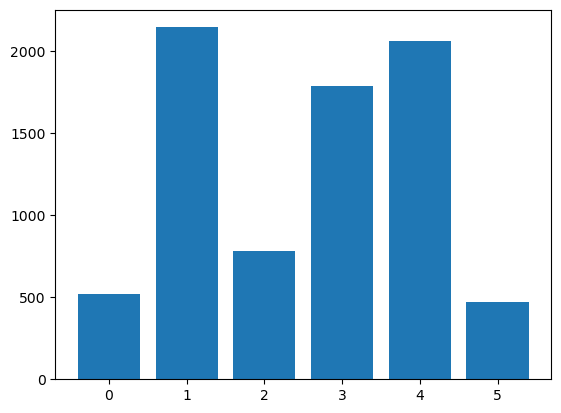

In [12]:
photos_by_emotions = e_images_filtered.groupby('label').count()
plt.bar(photos_by_emotions.index, photos_by_emotions['path']);

In [13]:
X = e_images_filtered['path']
y = e_images_filtered['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [44]:
Images = []
for i in X_train:
    image = cv.imread(f'dataset/{i}')
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    resize_image = cv.resize(rgb_image, (100, 100))
    std_image = resize_image / 255
    Images.append(std_image)

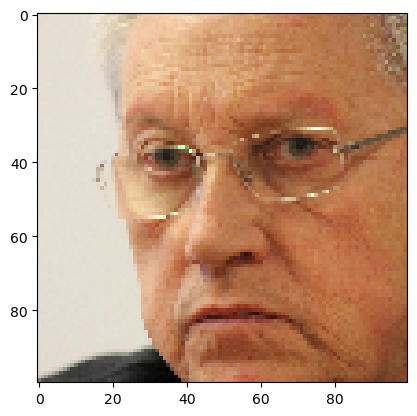

In [45]:
plt.imshow(Images[1001]);

In [15]:
#class CTDataset(Dataset):
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #def __init__(self, X, y):
        #self.x = 
        